In [158]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torchvision.models.detection as detection
from torch.optim import SGD
from torchvision.ops import box_iou
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import StepLR
from collections import defaultdict
from torch.nn.functional import softmax
from torchvision.ops import nms
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [159]:
class CustomDataset(Dataset):
    label_mapping = {
        'right normal': 1,
        'left normal': 2
    }

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Load all image paths and corresponding json paths
        for class_name in ['Cancer', 'Mix', 'Warthin']:
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.png'):
                    img_path = os.path.join(class_dir, img_name)
                    json_path = os.path.join(class_dir, img_name.replace('.png', '.json'))
                    self.samples.append((img_path, json_path, class_name))

    def __len__(self):
        return len(self.samples)


    def __getitem__(self, idx):
        img_path, json_path, class_name = self.samples[idx]

        # Load image and apply transformations
        image = Image.open(img_path).convert('RGB')
        original_size = image.size

        if self.transform is not None:
            image = self.transform(image)
        new_size = image.size()[-2:]

        # Load JSON
        with open(json_path, 'r') as file:
            annotation = json.load(file)

        target = {}
        boxes = []
        labels = []

        for shape in annotation['shapes']:
            label = shape['label'].lower()
            # Only process 'left_normal' and 'right_normal'
            if label not in ['left normal', 'right normal']:
                continue  # Skip labels that are not 'left_normal' or 'right_normal'

            label_value = self.label_mapping.get(label, None)
            if label_value is None:
                continue  # Skip if label is not found in label_mapping

            points = shape['points']
            x_coordinates, y_coordinates = zip(*points)
            x_min, x_max = min(x_coordinates), max(x_coordinates)
            y_min, y_max = min(y_coordinates), max(y_coordinates)

            # Scale the bounding box coordinates according to the image resize
            scale_x, scale_y = new_size[1] / original_size[0], new_size[0] / original_size[1]
            box = [x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y]
            boxes.append(box)
            labels.append(label_value)

        # Convert everything to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if boxes.nelement() != 0 else torch.zeros((0,), dtype=torch.float32)
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # Build the target dictionary
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target


In [160]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [161]:
# Create the dataset
dataset = CustomDataset(root_dir='data_20240105', transform=transform)

def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, 0)
    targets = [{k: torch.as_tensor(v) for k, v in t.items()} for t in targets]
    return images, targets

# Now use this collate_fn in your DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch 1
Images shape: torch.Size([1, 3, 256, 256])


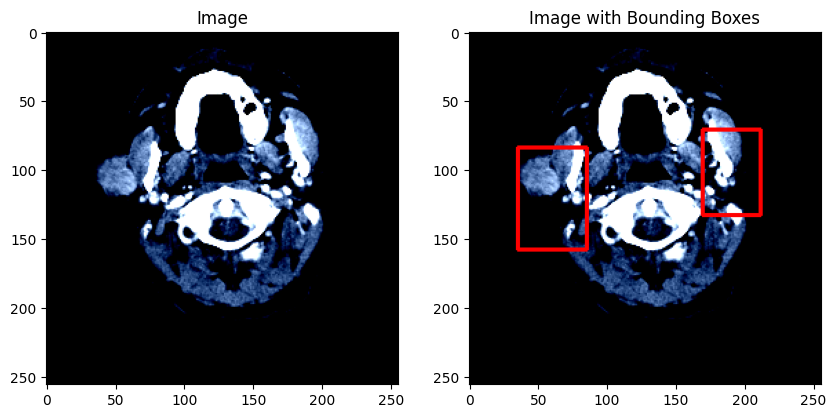

In [162]:
# Check a few batches
for batch_idx, (images, targets_list) in enumerate(data_loader):
    print(f"Batch {batch_idx+1}")
    print(f"Images shape: {images.shape}")  # Expect [batch_size, channels, height, width]

    # Visualize the first image in the batch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].permute(1, 2, 0).numpy(), cmap='gray')
    plt.title('Image')

    # Since we're using Faster R-CNN, we don't have masks, but we can visualize the bounding boxes
    current_image = images[0].permute(1, 2, 0).numpy().copy()
    for target in targets_list:
        boxes = target['boxes'].cpu().numpy()
        for box in boxes:
            cv2.rectangle(current_image, 
                          (int(box[0]), int(box[1])), 
                          (int(box[2]), int(box[3])), 
                          color=(255, 0, 0), 
                          thickness=2)

    plt.subplot(1, 2, 2)
    plt.imshow(current_image, cmap='gray')
    plt.title('Image with Bounding Boxes')
    plt.show()

    if batch_idx == 0:  # Just show 2 batches for checking
        break


In [163]:
import torchvision.models.detection as detection

def get_model(num_classes):
    # Load a model pre-trained on COCO
    model = detection.fasterrcnn_resnet50_fpn(weights=True)

    # Replace the classifier with a new one for our number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

# 2 classes + background
model = get_model(num_classes=3)

/mnt/data/home/willidragon/ImageProcessingHomeWork2/IMAGE_PROCESS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [164]:
def train_one_epoch(model, optimizer, scheduler, data_loader, device):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(data_loader, desc="Training", unit="batch"):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
    scheduler.step()
    return running_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    iou_sum = 0
    num_samples = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating", unit="batch"):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for target, output in zip(targets, outputs):
                iou = box_iou(target['boxes'], output['boxes'])
                iou_sum += iou.sum().item()
                num_samples += iou.numel()

    return iou_sum / num_samples

In [ ]:
# Define the number of folds for cross-validation
num_folds = 4
num_epochs = 5
kf = KFold(n_splits=num_folds, shuffle=True)

# Perform cross-validation
fold_performance = []
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
best_models = []
for fold, (train_ids, test_ids) in enumerate(kf.split(dataset)):
    # Split dataset into training and validation sets for the current fold
    train_subset = torch.utils.data.Subset(dataset, train_ids)
    val_subset = torch.utils.data.Subset(dataset, test_ids)

    # Prepare data loaders
    train_loader = DataLoader(train_subset, batch_size=1, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_subset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize the model for this fold
    model = get_model(num_classes=3).to(device)
    optimizer = SGD(model.parameters(), lr=0.003, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    
    best_iou = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Train the model
    for epoch in range(num_epochs):
        epoch_loss = train_one_epoch(model, optimizer, scheduler, train_loader, device)
        iou = evaluate(model, val_loader, device)
        print(f"Fold: {fold}, Epoch: {epoch}, Loss: {epoch_loss}, IoU: {iou}")
        
        # Early stopping and save best model
        if iou > best_iou:
            best_iou = iou
            best_model_wts = copy.deepcopy(model.state_dict())

    fold_performance.append(best_iou)
    best_models.append(best_model_wts)

# Save the best model for each fold
for fold, model_wts in enumerate(best_models):
    torch.save(model_wts, f'best_model_fold_{fold}.pth')

# Average performance
average_performance = sum(fold_performance) / len(fold_performance)
print(f"Average IoU over {num_folds} folds: {average_performance}")

In [166]:
models = []
for fold in range(num_folds):
    model = get_model(num_classes=3).to(device)
    model.load_state_dict(torch.load(f'best_model_fold_{fold}.pth'))
    model.eval()
    models.append(model)

# Assuming 'CustomDataset' and 'transform' are defined as before
test_dataset = CustomDataset(root_dir='data_20240105', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [167]:
def ensemble_predict_single_image(models, image_tensor, device, iou_threshold=0.5):
    # Ensure the image tensor is in the correct format and on the right device
    image_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        all_boxes = []
        all_labels = []
        all_scores = []

        for model in models:
            model = model.to(device)
            prediction = model(image_tensor)[0]

            scores = softmax(prediction['scores'], dim=0).to(device)  # Ensure scores are on the CUDA device
            labels = prediction['labels'].to(device)  # Ensure labels are on the CUDA device

            for box, label, score in zip(prediction['boxes'], labels, scores):
                all_boxes.append(box)
                all_labels.append(label)
                all_scores.append(score)

        # Group boxes by labels
        grouped_boxes = defaultdict(list)
        grouped_scores = defaultdict(list)

        for box, label, score in zip(all_boxes, all_labels, all_scores):
            grouped_boxes[label.item()].append(box)
            grouped_scores[label.item()].append(score)

        # Average boxes and find the label with the highest average score
        final_boxes = []
        final_labels = []

        for label, boxes in grouped_boxes.items():
            avg_box = torch.mean(torch.stack(boxes), dim=0)
            avg_score = torch.mean(torch.stack(grouped_scores[label]))
            final_boxes.append(avg_box)
            final_labels.append((label, avg_score))

        # Sort labels by average score and keep the label with the highest score
        final_labels = [label for label, _ in sorted(final_labels, key=lambda x: x[1], reverse=True)]
        final_boxes = torch.stack(final_boxes)

        # Apply NMS
        keep_indices = nms(final_boxes.to(device), torch.tensor(final_labels, device=device), iou_threshold)  # Ensure final_labels tensor is on CUDA
        final_prediction = {'boxes': final_boxes[keep_indices], 'labels': torch.tensor(final_labels, device=device)[keep_indices]}

    return final_prediction


image_path = 'demo_test9/c230-11996869_12.png'
image = Image.open(image_path).convert('RGB')
transformed_image = transform(image).to(device)  # The image is already transformed here
iou_threshold = 0.5  # Set a suitable IoU threshold value
ensemble_prediction = ensemble_predict_single_image(models, transformed_image, device, iou_threshold)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


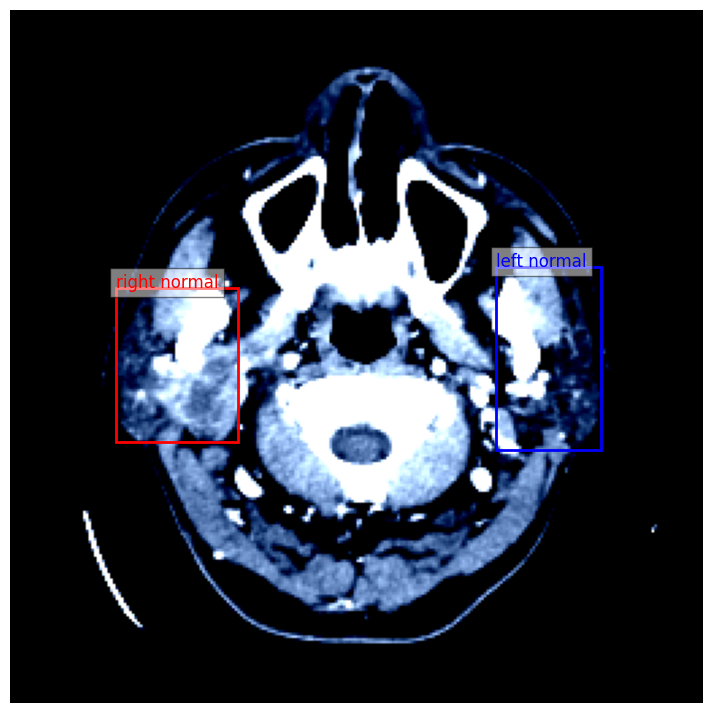

In [168]:
def draw_boxes(image, prediction):
    # Convert image tensor to numpy array
    image = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Disable axis ticks and labels
    ax.axis('off')

    # Extract boxes and labels
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    # Define colors and labels for your classes
    colors = {1: 'red', 2: 'blue'}
    class_labels = {1: 'right normal', 2: 'left normal'}

    # Draw boxes with labels
    for box, label in zip(boxes, labels):
        x, y, x2, y2 = box
        rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2,
                                 edgecolor=colors.get(label, 'green'), facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y, class_labels.get(label, 'unknown'),
                 color=colors.get(label, 'green'), fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

draw_boxes(transformed_image, ensemble_prediction)


In [169]:
def draw_ground_truth_boxes(image, ground_truth):
    # Convert image tensor to numpy array
    image = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Extract boxes and labels
    boxes = ground_truth['boxes'].cpu().numpy()
    labels = ground_truth['labels'].cpu().numpy()

    # Define colors and labels for your classes
    colors = {1: 'red', 2: 'blue'}
    class_labels = {1: 'right normal', 2: 'left normal'}

    # Draw boxes with labels
    for box, label in zip(boxes, labels):
        x, y, x2, y2 = box
        rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2,
                                 edgecolor=colors.get(label, 'green'), facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y, class_labels.get(label, 'unknown'),
                 color=colors.get(label, 'green'), fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()


def get_ground_truth_boxes(json_path, original_size, transformed_size):
    with open(json_path, 'r') as file:
        data = json.load(file)

    boxes = []
    labels = []

    for shape in data['shapes']:
        label = shape['label'].lower()
        # 只处理 'left_normal' 和 'right_normal'
        if label not in ['left normal', 'right normal']:
            continue

        points = shape['points']
        x_coordinates, y_coordinates = zip(*points)
        x_min, x_max = min(x_coordinates), max(x_coordinates)
        y_min, y_max = min(y_coordinates), max(y_coordinates)

        # Scale the bounding box coordinates according to the image resize
        scale_x, scale_y = transformed_size[1] / original_size[0], transformed_size[0] / original_size[1]
        box = [x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y]
        boxes.append(box)
        labels.append(label)

    return boxes, labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


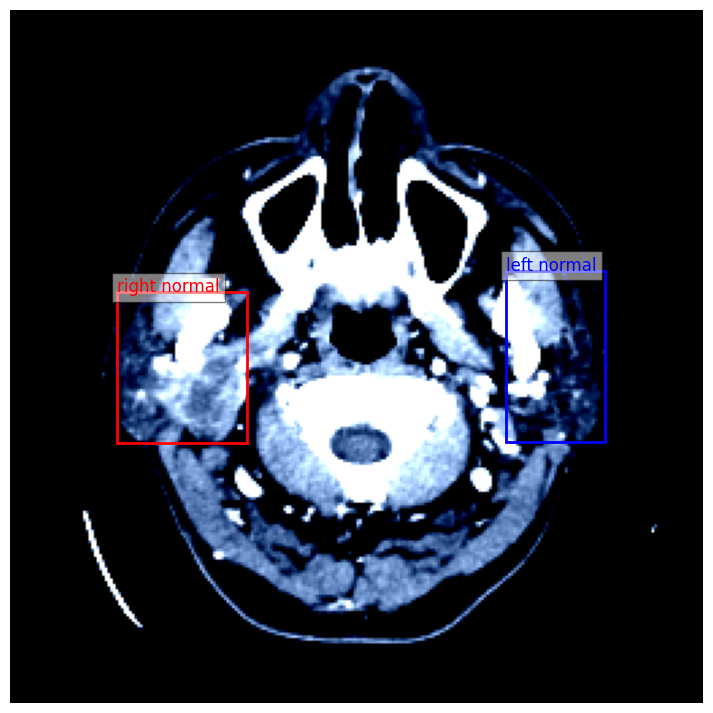

In [170]:
json_path = 'demo_test9/c230-11996869_12.json'
original_size = (512, 512)  # 假设原始大小为 512x512
transformed_size = (256, 256)  # 假设转换后的大小为 256x256
gt_boxes, gt_labels = get_ground_truth_boxes(json_path, original_size, transformed_size)

# Convert labels to numeric values
label_mapping = {'right normal': 1, 'left normal': 2}
numeric_labels = [label_mapping.get(label, 0) for label in gt_labels]


# Convert boxes and labels to the format expected by draw_boxes
ground_truth = {'boxes': torch.tensor(gt_boxes), 'labels': torch.tensor(numeric_labels)}

# Draw ground truth boxes on the image
draw_boxes(transformed_image, ground_truth)


In [171]:
def reorder_predictions(pred_boxes, pred_labels, gt_boxes, gt_labels):
    # 将边界框转换为tensor
    pred_boxes_tensor = torch.tensor(pred_boxes)
    gt_boxes_tensor = torch.tensor(gt_boxes)

    # 计算IoU
    ious = box_iou(gt_boxes_tensor, pred_boxes_tensor)

    # 找到每个真实框与预测框的最佳匹配
    matches = torch.argmax(ious, dim=1)

    # 重新排序预测框和标签
    sorted_pred_boxes = pred_boxes_tensor[matches].numpy()
    sorted_pred_labels = torch.tensor(pred_labels)[matches].numpy()

    return sorted_pred_boxes, sorted_pred_labels

sorted_pred_boxes, sorted_pred_labels = reorder_predictions(pred_boxes, pred_labels, gt_boxes, gt_labels)

In [172]:
def get_prediction_boxes(image, prediction):
    image = image.permute(1, 2, 0).cpu().numpy()

    # Extract boxes and labels directly from the prediction dictionary
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    return boxes, labels

# Usage
pred_boxes, pred_labels = get_prediction_boxes(transformed_image, ensemble_prediction)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


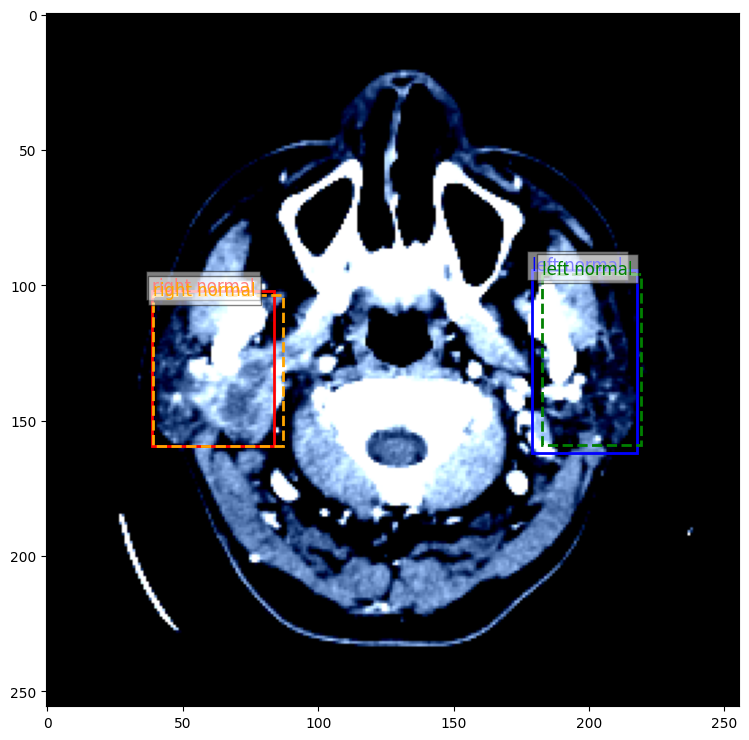

In [173]:
def draw_combined_boxes(image, prediction, ground_truth):
    # Convert image tensor to numpy array
    image = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Extract predicted boxes and labels
    pred_boxes = prediction['boxes'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()

    # Extract ground truth boxes and labels
    gt_boxes = ground_truth['boxes'].cpu().numpy()
    gt_labels = ground_truth['labels'].cpu().numpy()

    # Define colors and labels for your classes
    pred_colors = {1: 'red', 2: 'blue'}
    gt_colors = {1: 'orange', 2: 'green'}
    class_labels = {1: 'right normal', 2: 'left normal'}

    # Draw predicted boxes with labels
    for box, label in zip(pred_boxes, pred_labels):
        x, y, x2, y2 = box
        rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2,
                                 edgecolor=pred_colors.get(label, 'green'), facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y, class_labels.get(label, 'unknown'),
                 color=pred_colors.get(label, 'green'), fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    # Draw ground truth boxes with labels
    for box, label in zip(gt_boxes, gt_labels):
        x, y, x2, y2 = box
        rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2,
                                 edgecolor=gt_colors.get(label, 'yellow'), facecolor='none', linestyle='dashed')
        ax.add_patch(rect)
        plt.text(x, y, class_labels.get(label, 'unknown'),
                 color=gt_colors.get(label, 'yellow'), fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Draw both ensemble prediction and ground truth on the same image
draw_combined_boxes(transformed_image, ensemble_prediction, ground_truth)


In [174]:
def calculate_iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [175]:
def evaluate_and_print_individual_metrics(pred_boxes, gt_boxes, image_size):
    iou_threshold = 0.5
    all_points = image_size[0] * image_size[1]  # Total number of pixels in the image
    overall_iou_list = []

    # Initialize counters for overall metrics
    overall_TP = overall_FP = overall_FN = 0

    # Calculate and print individual metrics for each predicted box
    for i, pred_box in enumerate(pred_boxes):
        ious = np.array([calculate_iou(pred_box, gt_box) for gt_box in gt_boxes])
        max_iou = np.max(ious) if ious.size > 0 else 0
        overall_iou_list.append(max_iou)  # Add the IoU to the overall list
        max_iou_index = np.argmax(ious) if ious.size > 0 else -1

        if max_iou > iou_threshold:
            TP = 1
            overall_TP += 1
        else:
            TP = 0
            overall_FP += 1

        FP = 1 - TP
        FN = 1 - TP  # FN is 1 if there was no match (since it's a binary situation for each box)
        TN = all_points - (TP + FP + FN)  # Simplified assumption, not typically used

        # Calculate Precision, Recall, and Accuracy for the individual prediction
        Precision = TP / (TP + FP) if TP + FP > 0 else 0
        Recall = TP / (TP + FN) if TP + FN > 0 else 0
        Accuracy = (TP + TN) / (TP + FP + FN + TN) if all_points > 0 else 0

        print(f"Box {i} (Prediction): IoU: {max_iou}, Matched with Ground Truth Box: {max_iou_index}")
        print(f"Box {i} Metrics: Precision: {Precision}, Recall: {Recall}, Accuracy: {Accuracy}\n")

    # Calculate overall IoU as the average of individual IoUs
    overall_IoU = np.mean(overall_iou_list) if overall_iou_list else 0

    # Calculate FN for overall metrics by checking ground truth boxes that weren't matched
    matched_gt_boxes = set()
    for iou, gt_box in zip(ious, gt_boxes):
        if iou > iou_threshold:
            matched_gt_boxes.add(tuple(gt_box))  # Add matched ground truth box as a tuple to the set

    overall_FN = len(gt_boxes) - len(matched_gt_boxes)

    # Calculate overall Precision, Recall, and Accuracy
    overall_Precision = overall_TP / (overall_TP + overall_FP) if overall_TP + overall_FP > 0 else 0
    overall_Recall = overall_TP / (overall_TP + overall_FN) if overall_TP + overall_FN > 0 else 0
    overall_Accuracy = (overall_TP + (all_points - (overall_TP + overall_FP + overall_FN))) / all_points if all_points > 0 else 0

    return overall_Precision, overall_Recall, overall_Accuracy, overall_IoU

# Example usage:
image_size = (256, 256)  # Replace with your actual image size
overall_Precision, overall_Recall, overall_Accuracy, overall_IoU = evaluate_and_print_individual_metrics(pred_boxes, gt_boxes, image_size)
print(f"Overall Metrics: Precision: {overall_Precision}, Recall: {overall_Recall}, Accuracy: {overall_Accuracy}, IoU: {overall_IoU}")


Box 0 (Prediction): IoU: 0.8144032644567162, Matched with Ground Truth Box: 1
Box 0 Metrics: Precision: 1.0, Recall: 1.0, Accuracy: 1.0

Box 1 (Prediction): IoU: 0.8909140343249858, Matched with Ground Truth Box: 0
Box 1 Metrics: Precision: 1.0, Recall: 1.0, Accuracy: 1.0

Overall Metrics: Precision: 1.0, Recall: 0.6666666666666666, Accuracy: 0.9999847412109375, IoU: 0.852658649390851
